In [12]:
import pandas as pd;
import pingouin as pg;
import seaborn as sns;
import scipy.stats as stats;
import numpy as np
import matplotlib.pyplot as plt
import scikit_posthocs as scp
import statsmodels as st
import operator

Función que nos permite obtener el ranking utilizando el test no paramétrico de wilcoxon. 

In [64]:
def pairwise_test(df, parametric = True, method = 'bonferroni', decreasing = True, ties=True):
    # Función que devuelve la matriz de rankings.
    # El dataframe de entrada df debe tener los modelos en las columnas y 
    # las medidas en las filas. 
    # parametric = indica si se aplica un test paramétrico (ttest_rel) o no paramétrico (wilcoxon)
    # decreasing = indica el sentido en el que es mejor la medida utilizada. 
    # ties = indca si se incluyen los empates en el resultado final 
    
    if decreasing:
        relate = operator.lt
    else:
        relate = operator.gt
    
    if parametric:
        test = stats.ttest_rel
    else:
        test = stats.wilcoxon
        
    cols = df.columns
    pvalues = np.array([])
    significant = np.array([])
    ranks = pd.DataFrame({"wins":np.zeros(len(cols)),
                         "ties":np.zeros(len(cols)),
                         "losses":np.zeros(len(cols))})
    ranks.index= cols
    for index1 in range(len(cols)):
        for index2 in range(index1+1,len(cols)):
            T,p = test(df.iloc[:,index1],df.iloc[:,index2])
            pvalues = np.append(pvalues,p)
            
    significant,padjust,a1,a2 = st.stats.multitest.multipletests(pvalues,alpha = 0.05,method = method)

    
    pos = 0;
    for index1 in range(len(cols)):
        for index2 in range(index1+1,len(cols)):
            if not significant[pos]:
                ranks.iloc[index1,1] = ranks.iloc[index1,1]+1
                ranks.iloc[index2,1] = ranks.iloc[index2,1]+1
            else:  
                if relate(df.iloc[:,index1].mean(),df.iloc[:,index2].mean()):
                    ranks.iloc[index1,0] = ranks.iloc[index1,0]+1
                    ranks.iloc[index2,2] = ranks.iloc[index2,2]+1
                else:
                    ranks.iloc[index2,0] = ranks.iloc[index2,0]+1
                    ranks.iloc[index1,2] = ranks.iloc[index1,2]+1
            pos = pos + 1
                
    ranks["diff"] = ranks.wins-ranks.losses
    #ranks = ranks.sort_values(by="diff",ascending = False)
    if  not ties:
        ranks.drop('ties',axis = 'columns', inplace = True)
    return ranks.astype(int) 

# RSME

Lectura de la tabla con el RSME en cada fold

In [14]:
tabla_rsme = pd.read_csv('../Datos_preprocesados/RMSE_errores_train.csv')
tabla_rsme

,Pliegues,RF_lag3,RF_lag5,LR_lag3,LR_lag5,Lasso_lag3,Lasso_lag5,SVR_lag3,SVR_lag5,GBR_lag3,GBR_lag5,EN_lag3,EN_lag5
0,Fold 1,0.010250,0.012253,0.040040,0.021895,0.010777,0.012175,0.015468,0.017608,0.009779,0.011421,0.009565,0.011302
1,Fold 2,0.003465,0.005035,0.006011,0.008859,0.005831,0.004163,0.006113,0.004916,0.003236,0.005702,0.005437,0.004665
2,Fold 3,0.002359,0.002950,0.002599,0.004666,0.002282,0.002253,0.007964,0.006088,0.002058,0.001663,0.002220,0.002200
3,Fold 4,0.005817,0.005213,0.008027,0.008158,0.006893,0.007117,0.012659,0.018517,0.005418,0.005386,0.006962,0.007347
4,Fold 5,0.019228,0.018612,0.015113,0.017661,0.014720,0.014294,0.018877,0.022049,0.018109,0.019953,0.015303,0.015526
5,Fold 6,0.097717,0.099564,0.030118,0.027917,0.031447,0.029454,0.031626,0.026445,0.094637,0.099538,0.031492,0.028937
6,Fold 7,0.054043,0.054168,0.047621,0.046455,0.048174,0.044944,0.050317,0.046399,0.049422,0.054665,0.048253,0.045141
7,Fold 8,0.117732,0.113723,0.064359,0.061369,0.063967,0.061773,0.066249,0.059950,0.118328,0.118405,0.064465,0.062454
8,Fold 9,0.124888,0.141807,0.085793,0.091884,0.085716,0.091056,0.089009,0.093796,0.121939,0.142605,0.085260,0.091053
9,Fold 10,0.060135,0.064386,0.029916,0.038327,0.029938,0.036199,0.029868,0.036866,0.048429,0.046525,0.029645,0.035670


eliminados la columna con los pliegues porque esa información está en el índice

In [15]:
tabla_rsme.drop(columns = "Pliegues", inplace=True)

In [16]:
tabla_rsme.describe()

,RF_lag3,RF_lag5,LR_lag3,LR_lag5,Lasso_lag3,Lasso_lag5,SVR_lag3,SVR_lag5,GBR_lag3,GBR_lag5,EN_lag3,EN_lag5
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.049563,0.051771,0.032960,0.032719,0.029975,0.030343,0.032815,0.033264,0.047135,0.050586,0.029860,0.030430
std,0.048881,0.051414,0.027178,0.027624,0.028047,0.028913,0.027536,0.027363,0.048149,0.052089,0.028119,0.028922
min,0.002359,0.002950,0.002599,0.004666,0.002282,0.002253,0.006113,0.004916,0.002058,0.001663,0.002220,0.002200
25%,0.006925,0.006973,0.009799,0.011060,0.007864,0.008381,0.013362,0.017836,0.006509,0.007132,0.007613,0.008336
50%,0.036635,0.036390,0.030017,0.024906,0.022329,0.021874,0.024372,0.024247,0.033269,0.033239,0.022474,0.022231
75%,0.088322,0.090770,0.045726,0.044423,0.043993,0.042758,0.045644,0.044016,0.083333,0.088320,0.044063,0.042774
max,0.124888,0.141807,0.085793,0.091884,0.085716,0.091056,0.089009,0.093796,0.121939,0.142605,0.085260,0.091053


<AxesSubplot:>

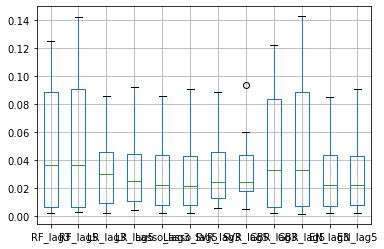

In [17]:
tabla_rsme.boxplot()

Busca otras formas de mostrar los boxplot para que las gráficas salgan mejor en la documentación. 

Primero analizamos si las diferentes muestras (resultados de la validación cruzada por cada modelo) proceden de una distribución normal. Para ello vamos a aplicar el test de Shapiro-Wilks. 

In [18]:
tabla_rsme.apply(stats.shapiro)

,RF_lag3,RF_lag5,LR_lag3,LR_lag5,Lasso_lag3,Lasso_lag5,SVR_lag3,SVR_lag5,GBR_lag3,GBR_lag5,EN_lag3,EN_lag5
0,0.848849,0.865220,0.926488,0.894526,0.881280,0.884259,0.874023,0.886962,0.833152,0.855404,0.880959,0.884850
1,0.056286,0.087896,0.414248,0.190580,0.134982,0.145986,0.111330,0.156691,0.036515,0.067338,0.133844,0.148267


Como pdemos ver, exite un pvalue que es menor que el nivel de significancia del 0.05, GBR_lag3 con lo que en ese caso la distribución no sigue una distribución normal. Esto lo podemos ver de forma gráfica. 

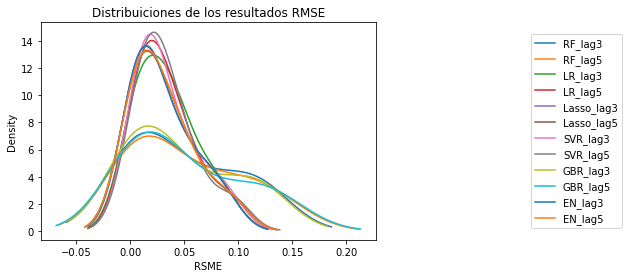

In [19]:
f = plt.figure()
plt.title("Distribuiciones de los resultados RMSE")
tabla_rsme.plot(kind='density', ax=f.gca())
f.gca().set_xlabel('RSME')
plt.legend(loc='right', bbox_to_anchor=(1.75,0.5))

In [20]:
test = stats.friedmanchisquare(*[tabla_rsme[col] for col in tabla_rsme.columns])
test

FriedmanchisquareResult(statistic=22.907692307692344, pvalue=0.018212427063207203)

Como se puede ver no se detectan diferencias signficativas. Si intentamos aplicar el test de Nemenyi tampoco las encuentra. 

In [21]:
scp.posthoc_nemenyi_friedman(tabla_rsme, melted=False)

,RF_lag3,RF_lag5,LR_lag3,LR_lag5,Lasso_lag3,Lasso_lag5,SVR_lag3,SVR_lag5,GBR_lag3,GBR_lag5,EN_lag3,EN_lag5
RF_lag3,1.000000,0.900000,0.9,0.900000,0.833739,0.599927,0.900000,0.900000,0.9,0.900000,0.677865,0.638894
RF_lag5,0.900000,1.000000,0.9,0.900000,0.440001,0.212062,0.900000,0.900000,0.9,0.900000,0.277058,0.242858
LR_lag3,0.900000,0.900000,1.0,0.900000,0.900000,0.900000,0.900000,0.900000,0.9,0.900000,0.900000,0.900000
LR_lag5,0.900000,0.900000,0.9,1.000000,0.900000,0.794768,0.900000,0.900000,0.9,0.900000,0.872707,0.833739
Lasso_lag3,0.833739,0.440001,0.9,0.900000,1.000000,0.900000,0.599927,0.900000,0.9,0.560957,0.900000,0.900000
Lasso_lag5,0.599927,0.212062,0.9,0.794768,0.900000,1.000000,0.353264,0.872707,0.9,0.313427,0.900000,0.900000
SVR_lag3,0.900000,0.900000,0.9,0.900000,0.599927,0.353264,1.000000,0.900000,0.9,0.900000,0.440001,0.396312
SVR_lag5,0.900000,0.900000,0.9,0.900000,0.900000,0.872707,0.900000,1.000000,0.9,0.900000,0.900000,0.900000
GBR_lag3,0.900000,0.900000,0.9,0.900000,0.900000,0.900000,0.900000,0.900000,1.0,0.900000,0.900000,0.900000
GBR_lag5,0.900000,0.900000,0.9,0.900000,0.560957,0.313427,0.900000,0.900000,0.9,1.000000,0.396312,0.353264


Para facilitar el cáluclo de la matriz de ranking, vamos a utilizar la función que definimos antes que utiliza el test de Wilcoxon.

In [65]:
rsme_ranks = pairwise_test(tabla_rsme, parametric=False, decreasing=True, ties= False, method="holm")
rsme_ranks

,wins,losses,diff
RF_lag3,0,0,0
RF_lag5,0,0,0
LR_lag3,0,0,0
LR_lag5,0,0,0
Lasso_lag3,0,0,0
Lasso_lag5,0,0,0
SVR_lag3,0,0,0
SVR_lag5,0,0,0
GBR_lag3,0,0,0
GBR_lag5,0,0,0


# MAE

In [38]:
tabla_mae = pd.read_csv('../Datos_preprocesados/MAE_errores_train.csv')
tabla_mae

,Pliegues,RF_lag3,RF_lag5,LR_lag3,LR_lag5,Lasso_lag3,Lasso_lag5,SVR_lag3,SVR_lag5,GBR_lag3,GBR_lag5,EN_lag3,EN_lag5
0,Fold 1,0.008462,0.011392,0.032479,0.014992,0.007227,0.007082,0.012623,0.017494,0.007774,0.009879,0.006476,0.005981
1,Fold 2,0.003400,0.005021,0.004186,0.003734,0.004024,0.002734,0.005366,0.003984,0.003021,0.005115,0.003658,0.003443
2,Fold 3,0.001714,0.002173,0.001866,0.003266,0.001329,0.001685,0.005990,0.004277,0.001440,0.001243,0.001306,0.001632
3,Fold 4,0.002247,0.002934,0.003994,0.002763,0.002256,0.002159,0.007597,0.010134,0.001828,0.001652,0.001959,0.002001
4,Fold 5,0.012167,0.013229,0.011721,0.007150,0.011192,0.012083,0.014557,0.018390,0.012484,0.013561,0.012501,0.012333
5,Fold 6,0.084448,0.087158,0.016943,0.016096,0.017917,0.016959,0.021310,0.012787,0.082231,0.087985,0.020494,0.016918
6,Fold 7,0.033824,0.033456,0.026278,0.026127,0.025823,0.027261,0.034723,0.028557,0.022534,0.032382,0.026455,0.025546
7,Fold 8,0.065309,0.056947,0.036142,0.032730,0.035894,0.033170,0.040139,0.031767,0.074404,0.061051,0.037323,0.032217
8,Fold 9,0.098532,0.118379,0.052798,0.042889,0.055291,0.043395,0.059637,0.043899,0.099885,0.115925,0.054401,0.042336
9,Fold 10,0.043867,0.055397,0.020134,0.024806,0.020085,0.023185,0.018272,0.020647,0.030652,0.040988,0.019380,0.022019


In [29]:
tabla_mae.drop(columns = "Pliegues", inplace=True)

<AxesSubplot:>

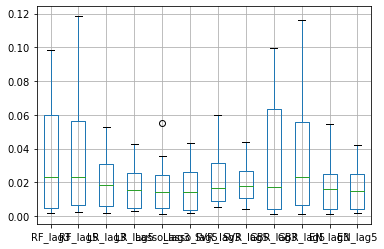

In [51]:
tabla_mae.boxplot()

In [30]:
tabla_mae.apply(stats.shapiro)

,RF_lag3,RF_lag5,LR_lag3,LR_lag5,Lasso_lag3,Lasso_lag5,SVR_lag3,SVR_lag5,GBR_lag3,GBR_lag5,EN_lag3,EN_lag5
0,0.859676,0.862087,0.935417,0.912743,0.886039,0.917546,0.869829,0.946054,0.813711,0.859454,0.894716,0.919158
1,0.075641,0.080753,0.503236,0.300371,0.152955,0.336944,0.099508,0.622112,0.021268,0.075186,0.191508,0.349987


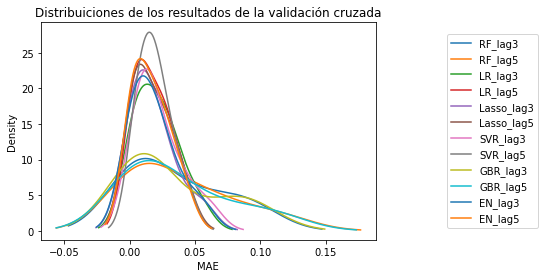

In [31]:
f = plt.figure()
plt.title("Distribuiciones de los resultados de la validación cruzada")
tabla_mae.plot(kind='density', ax=f.gca())
f.gca().set_xlabel('MAE')
plt.legend(loc='right', bbox_to_anchor=(1.5,0.5))

Al igual que antes he hecho el test en R y se rechaza la hipótesis nula de que se cumple la esfericidad

In [33]:
test = stats.friedmanchisquare(*[tabla_mae[col] for col in tabla_mae.columns])
test

FriedmanchisquareResult(statistic=34.584615384615404, pvalue=0.0002900649084931501)

In [34]:
scp.posthoc_nemenyi_friedman(tabla_mae, melted=False)

,RF_lag3,RF_lag5,LR_lag3,LR_lag5,Lasso_lag3,Lasso_lag5,SVR_lag3,SVR_lag5,GBR_lag3,GBR_lag5,EN_lag3,EN_lag5
RF_lag3,1.000000,0.900000,0.900000,0.900000,0.716832,0.599927,0.900000,0.900000,0.900000,0.900000,0.716832,0.183504
RF_lag5,0.900000,1.000000,0.638894,0.183504,0.068963,0.038871,0.900000,0.872707,0.440001,0.900000,0.068963,0.003226
LR_lag3,0.900000,0.638894,1.000000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.677865
LR_lag5,0.900000,0.183504,0.900000,1.000000,0.900000,0.900000,0.440001,0.900000,0.900000,0.833739,0.900000,0.900000
Lasso_lag3,0.716832,0.068963,0.900000,0.900000,1.000000,0.900000,0.212062,0.900000,0.900000,0.599927,0.900000,0.900000
Lasso_lag5,0.599927,0.038871,0.900000,0.900000,0.900000,1.000000,0.135020,0.872707,0.900000,0.482355,0.900000,0.900000
SVR_lag3,0.900000,0.900000,0.900000,0.440001,0.212062,0.135020,1.000000,0.900000,0.716832,0.900000,0.212062,0.016850
SVR_lag5,0.900000,0.872707,0.900000,0.900000,0.900000,0.872707,0.900000,1.000000,0.900000,0.900000,0.900000,0.440001
GBR_lag3,0.900000,0.440001,0.900000,0.900000,0.900000,0.900000,0.716832,0.900000,1.000000,0.900000,0.900000,0.872707
GBR_lag5,0.900000,0.900000,0.900000,0.833739,0.599927,0.482355,0.900000,0.900000,0.900000,1.000000,0.599927,0.115746


In [35]:
mae_ranks = pairwise_test(tabla_mae,decreasing = True,parametric=False, ties=False).sort_index()
mae_ranks 

,wins,losses,diff
EN_lag3,0,0,0
EN_lag5,0,0,0
GBR_lag3,0,0,0
GBR_lag5,0,0,0
LR_lag3,0,0,0
LR_lag5,0,0,0
Lasso_lag3,0,0,0
Lasso_lag5,0,0,0
RF_lag3,0,0,0
RF_lag5,0,0,0


In [36]:
final_ranks = pd.concat([rsme_ranks,mae_ranks], axis=1)
final_ranks

,wins,ties,losses,diff,wins,losses,diff
RF_lag3,0,11,0,0,0,0,0
RF_lag5,0,11,0,0,0,0,0
LR_lag3,0,11,0,0,0,0,0
LR_lag5,0,11,0,0,0,0,0
Lasso_lag3,0,11,0,0,0,0,0
Lasso_lag5,0,11,0,0,0,0,0
SVR_lag3,0,11,0,0,0,0,0
SVR_lag5,0,11,0,0,0,0,0
GBR_lag3,0,11,0,0,0,0,0
GBR_lag5,0,11,0,0,0,0,0


# R^2

In [39]:
tabla_R2 = pd.read_csv('../Datos_preprocesados/R2_errores_train.csv')
tabla_R2

,Pliegues,RF_lag3,RF_lag5,LR_lag3,LR_lag5,Lasso_lag3,Lasso_lag5,SVR_lag3,SVR_lag5,GBR_lag3,GBR_lag5,EN_lag3,EN_lag5
0,Fold 1,-29.694342,-42.863114,-467.380863,-139.060110,-32.932006,-42.304050,-68.902018,-89.585501,-26.941164,-37.108063,-25.730847,-36.321997
1,Fold 2,-12.057997,-26.565429,-38.290436,-84.342924,-35.962679,-17.841906,-39.632676,-25.276891,-10.383378,-34.350915,-31.139927,-22.665800
2,Fold 3,-2.497690,-4.467829,-3.245419,-12.683312,-2.272921,-2.189557,-38.856047,-22.291884,-1.661564,-0.737697,-2.098041,-2.041702
3,Fold 4,0.208589,0.364302,-0.507292,-0.556680,-0.111366,-0.184671,-2.748629,-7.020625,0.313296,0.321470,-0.133801,-0.262629
4,Fold 5,-0.550522,-0.452815,0.042057,-0.308119,0.091258,0.143046,-0.494423,-1.038993,-0.375323,-0.669630,0.017847,-0.010932
5,Fold 6,-3.250044,-3.412252,0.596246,0.653112,0.559831,0.613866,0.554808,0.688739,-2.986368,-3.409879,0.558570,0.627305
6,Fold 7,-0.253955,-0.259751,0.026343,0.073442,0.003598,0.132760,-0.086999,0.075686,-0.048672,-0.283003,0.000338,0.125114
7,Fold 8,-0.479284,-0.380258,0.557943,0.598060,0.563308,0.592751,0.531592,0.616436,-0.494295,-0.496241,0.556486,0.583722
8,Fold 9,0.035836,-0.243110,0.544993,0.478093,0.545815,0.487454,0.510247,0.456143,0.080832,-0.257130,0.550628,0.487489
9,Fold 10,-2.836451,-3.398041,0.050516,-0.558438,0.049111,-0.390182,0.053565,-0.441872,-1.488205,-1.296420,0.067631,-0.349833


In [40]:
tabla_R2.drop(columns = "Pliegues", inplace=True)

<AxesSubplot:>

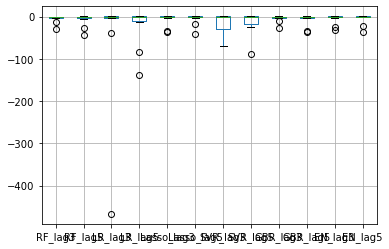

In [52]:
tabla_R2.boxplot()

In [41]:
tabla_R2.apply(stats.shapiro)

,RF_lag3,RF_lag5,LR_lag3,LR_lag5,Lasso_lag3,Lasso_lag5,SVR_lag3,SVR_lag5,GBR_lag3,GBR_lag5,EN_lag3,EN_lag5
0,0.621734,0.632764,4.100140e-01,0.585167,0.559081,0.563614,0.681564,0.611185,0.605377,0.571564,0.575009,0.586139
1,0.000101,0.000136,3.256374e-07,0.000037,0.000018,0.000020,0.000527,0.000075,0.000064,0.000025,0.000028,0.000038


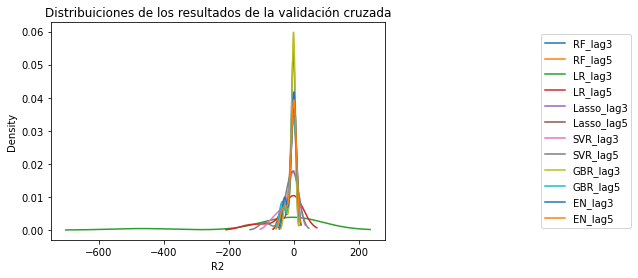

In [43]:
f = plt.figure()
plt.title("Distribuiciones de los resultados de la validación cruzada")
tabla_R2.plot(kind='density', ax=f.gca())
f.gca().set_xlabel('R2')
plt.legend(loc='right', bbox_to_anchor=(1.75,0.5))

En este caso podemos ver que las distribuciones proceden de una distribución normal. Esto nos lleva a comprobar lo otra condición de parametricida, la homocedasticidad o la esfericidad. Para ello vamos a aplicar el test de Mauchly

In [46]:
test = stats.friedmanchisquare(*[tabla_R2[col] for col in tabla_R2.columns])
test

FriedmanchisquareResult(statistic=22.907692307692344, pvalue=0.018212427063207203)

In [47]:
scp.posthoc_nemenyi_friedman(tabla_R2, melted=False)

,RF_lag3,RF_lag5,LR_lag3,LR_lag5,Lasso_lag3,Lasso_lag5,SVR_lag3,SVR_lag5,GBR_lag3,GBR_lag5,EN_lag3,EN_lag5
RF_lag3,1.000000,0.900000,0.9,0.900000,0.833739,0.599927,0.900000,0.900000,0.9,0.900000,0.677865,0.638894
RF_lag5,0.900000,1.000000,0.9,0.900000,0.440001,0.212062,0.900000,0.900000,0.9,0.900000,0.277058,0.242858
LR_lag3,0.900000,0.900000,1.0,0.900000,0.900000,0.900000,0.900000,0.900000,0.9,0.900000,0.900000,0.900000
LR_lag5,0.900000,0.900000,0.9,1.000000,0.900000,0.794768,0.900000,0.900000,0.9,0.900000,0.872707,0.833739
Lasso_lag3,0.833739,0.440001,0.9,0.900000,1.000000,0.900000,0.599927,0.900000,0.9,0.560957,0.900000,0.900000
Lasso_lag5,0.599927,0.212062,0.9,0.794768,0.900000,1.000000,0.353264,0.872707,0.9,0.313427,0.900000,0.900000
SVR_lag3,0.900000,0.900000,0.9,0.900000,0.599927,0.353264,1.000000,0.900000,0.9,0.900000,0.440001,0.396312
SVR_lag5,0.900000,0.900000,0.9,0.900000,0.900000,0.872707,0.900000,1.000000,0.9,0.900000,0.900000,0.900000
GBR_lag3,0.900000,0.900000,0.9,0.900000,0.900000,0.900000,0.900000,0.900000,1.0,0.900000,0.900000,0.900000
GBR_lag5,0.900000,0.900000,0.9,0.900000,0.560957,0.313427,0.900000,0.900000,0.9,1.000000,0.396312,0.353264


De la mismoa forma que hemos hecho para el caso no paramétrico, para automatizar los cálculos vamos a aplicar el T-test con la corrección de Bonferroni.

In [48]:
cc_ranks = pairwise_test(tabla_R2,parametric=False,decreasing=False,ties=False).sort_index()
cc_ranks

,wins,losses,diff
EN_lag3,0,0,0
EN_lag5,0,0,0
GBR_lag3,0,0,0
GBR_lag5,0,0,0
LR_lag3,0,0,0
LR_lag5,0,0,0
Lasso_lag3,0,0,0
Lasso_lag5,0,0,0
RF_lag3,0,0,0
RF_lag5,0,0,0


In [49]:
final_ranks = pd.concat([rsme_ranks,mae_ranks,cc_ranks], axis=1)
final_ranks

,wins,losses,diff,wins,losses,diff,wins,losses,diff
RF_lag3,0,0,0,0,0,0,0,0,0
RF_lag5,0,0,0,0,0,0,0,0,0
LR_lag3,0,0,0,0,0,0,0,0,0
LR_lag5,0,0,0,0,0,0,0,0,0
Lasso_lag3,0,0,0,0,0,0,0,0,0
Lasso_lag5,0,0,0,0,0,0,0,0,0
SVR_lag3,0,0,0,0,0,0,0,0,0
SVR_lag5,0,0,0,0,0,0,0,0,0
GBR_lag3,0,0,0,0,0,0,0,0,0
GBR_lag5,0,0,0,0,0,0,0,0,0


In [50]:
#shopper_rank.to_csv('../Data_Produced/shopper_rank_ranks.csv')
#shopper_rank.to_latex('../Data_Produced/shopper_rank_ranks.tex')